# French **&rarr;** English GRU Translator

French to English translator using GRU Encoder - Decoder model. Network was trained on over 170 000 pairs of sentences and after 20 epochs validation loss function started to plateau at ~0.83. Training was done using Google Colab GPU in eta. 1 hour. Entire model consists of 3 networks: Encoder, Decoder and Model that was created by connecting Encoder's output (hidden state) to one of the Decoder's inputs. 

Results are mixed since model is capable of translating short phrases but fails to translate longer ones... and sometimes short ones too. One way of fixing that would be to further train model with longer sequences.

In [77]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.layers import Input, Dense, GRU, Embedding, Dropout
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [2]:
# file with pair of sentences
sentences_file = 'Data/fra.txt'

# sizes of vocabularies used in tokenizers
en_vocab = 10000
fr_vocab = 10000

### Load and inspect data

In [3]:
# read and glympse data
df = pd.read_csv(sentences_file, sep='\t', usecols=[0,1], names=['en', 'fr'])
df.sample(3)

,en,fr
90121,I really miss my girlfriend.,Ma petite copine me manque vraiment.
178920,I've spent way too much time thinking about th...,J'ai passé beaucoup trop de temps à penser à c...
87423,"You're in pain, aren't you?","Tu souffres, n'est-ce pas ?"


In [4]:
# get lenths of sentences
en_lens = df['en'].apply(lambda x: len(x.split())).to_numpy()
fr_lens = df['fr'].apply(lambda x: len(x.split())).to_numpy()

In [5]:
# calculate max lenghts of input and output sequences
# +2 for <start> and <end> tokens
max_en_len = int(np.mean(en_lens) + 3*np.std(en_lens)) + 2 
max_fr_len = int(np.mean(fr_lens) + 3*np.std(fr_lens))

In [313]:
# function used to get general statistics
def print_statistics(lens, max_len, code):
    if code == 'en':
        max_len -= 2
    print('\t\t', code, ' statistics')
    print('max en length:\t\t\t\t', np.max(lens))
    print('min en length:\t\t\t\t', np.min(lens))
    print('max sequence length:\t\t\t', max_len)
    print(f'no. of seqs smaller than max_{code}_len:\t', np.sum(lens <= max_len))
    print(f'no. of seqs greater than max_{code}_len:\t', np.sum(lens > max_len))
    print('no. of seqs in total:\t\t\t', len(lens))
    print()
    print()

In [314]:
print_statistics(en_lens, max_en_len, 'en')
print_statistics(fr_lens, max_fr_len, 'fr')

		 en  statistics
max en length:				 44
min en length:				 1
max sequence length:			 13
no. of seqs smaller than max_en_len:	 183147
no. of seqs greater than max_en_len:	 2436
no. of seqs in total:			 185583


		 fr  statistics
max en length:				 55
min en length:				 1
max sequence length:			 15
no. of seqs smaller than max_fr_len:	 183695
no. of seqs greater than max_fr_len:	 1888
no. of seqs in total:			 185583




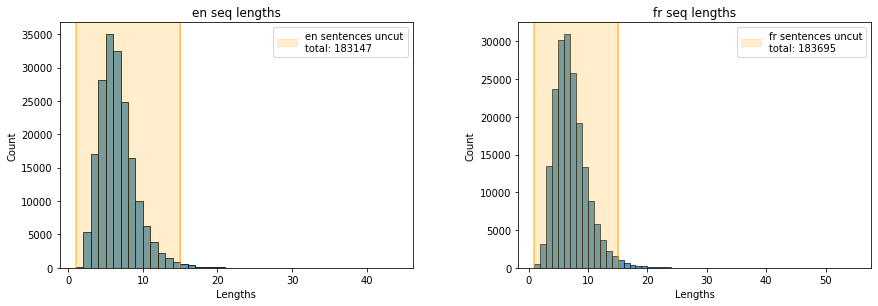

In [315]:
# visualize lengths of sequences in dataset
fig, axes = plt.subplots(1, 2, figsize=(12,4))
fig.tight_layout()

sns.histplot(en_lens, binwidth=1, bins=[i for i in range(max_en_len)], ax=axes[0])
axes[0].axvline(max_en_len, color='orange', alpha=0.6)
axes[0].axvline(en_lens.min(), color='orange', alpha=0.6)
axes[0].axvspan(en_lens.min(), max_en_len, alpha=0.2, color='orange', label=f'en sentences uncut\ntotal: {np.sum(en_lens <= max_en_len-2)}')
axes[0].set_title('en seq lengths')
axes[0].set_xlabel('Lengths')
axes[0].legend()

sns.histplot(fr_lens, binwidth=1, bins=[i for i in range(max_fr_len)], ax=axes[1])
axes[1].axvline(max_fr_len, color='orange', alpha=0.6)
axes[1].axvline(fr_lens.min(), color='orange', alpha=0.6)
axes[1].axvspan(fr_lens.min(), max_fr_len, alpha=0.2, color='orange', label=f'fr sentences uncut\ntotal: {np.sum(fr_lens <= max_fr_len)}')
axes[1].set_title('fr seq lengths')
axes[1].set_xlabel('Lengths')
axes[1].legend()

plt.subplots_adjust(wspace=0.3)
plt.show()

### Preprocess Data

In [6]:
# romved '<' and '>' characters and added digits
filters = '1234567890!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'

In [7]:
# insert <start> and <end> tokens
# it is not the best method though :V 
df['en'] = df['en'].apply(lambda x: '<start> ' + ' '.join(x.split(' ')[:max_en_len-2]) + ' <end>')
df.sample(3)

,en,fr
179736,"<start> Tom wanted one, but he had no idea whe...","Tom en voulait une, mais il n'avait aucune idé..."
31457,<start> Where are you hurt? <end>,Où es-tu blessé ?
181295,<start> How much time do you actually spend th...,Combien de temps passez-vous réellement à réfl...


In [8]:
# initialize tokenizers 
en_tokenizer = Tokenizer(num_words=en_vocab, filters=filters)
fr_tokenizer = Tokenizer(num_words=fr_vocab, filters=filters)

In [9]:
# fit tokenizers with texts
en_tokenizer.fit_on_texts(df['en'])
fr_tokenizer.fit_on_texts(df['fr'])

In [10]:
def create_dataset(df, fr_tok, en_tok, max_fr_len=max_fr_len, max_en_len=max_en_len, random_state=2018):
    '''
    function used to create datasets
    
    df:           dataframe with sentences
    fr_tok:       french tokenizer
    en_tok:       english tokenizer
    max_fr_len:   max french sequence length
    max_en_len:   max english sequence length
    random_state: used in shuffling
    '''
    
    # initialize empty arrays for fr and en sequences
    x = np.empty((len(df), max_fr_len), dtype='int')
    y = np.empty((len(df), max_en_len), dtype='int')
    
    # iterate over dataframe
    for idx in tqdm(range(len(df)), total=len(df)):
        
        # tokenize and cut sequences to chosen length
        inputs  = fr_tok.texts_to_sequences([df['fr'].iloc[idx]])[0][:max_fr_len]
        targets = en_tok.texts_to_sequences([df['en'].iloc[idx]])[0][:max_en_len]
        
        # double check wheter end token is in the right place
        # as I said, not the smartest approach :VVV
        if targets[-1] != en_tok.word_index['<end>']:
            targets[-1] = en_tok.word_index['<end>']
        
        # some studies have shown that reversing input gives better results
        # padding is done before input sequence
        pad_inputs = pad_sequences([inputs[::-1]], padding='pre', maxlen=max_fr_len)[0]
        
        # post padding output sequence
        pad_targets = pad_sequences([targets], padding='post', maxlen=max_en_len)[0]
        
        # insert sequences to proper arrays
        x[idx, :] = pad_inputs
        y[idx, :] = pad_targets
        
    # shuffling with given seed
    x, y = shuffle(x, y, random_state=random_state)
        
    # return sequences
    return np.array(x), np.array(y)

In [11]:
# generate source and target arrays
src, dst = create_dataset(df, fr_tokenizer, en_tokenizer)

In [12]:
# split into proper sizes
# shuffle is False
xtrain, xtest, ytrain, ytest = train_test_split(src, dst, train_size=0.9, shuffle=False)

In [13]:
print(xtrain.shape, xtrain.shape)
print(ytrain.shape, ytest.shape)

(167024, 15) (167024, 15)
(167024, 15) (18559, 15)


### The Model Architecture

In [75]:
# config for the Network
hidden_state = 256
embedding_size = 128

In [78]:
# Encoder
enc_input = Input(shape=(None,), name='enc_input')
enc_embedding = Embedding(fr_vocab, embedding_size)
enc_gru1 = GRU(hidden_state, return_sequences=True)
enc_gru2 = GRU(hidden_state, return_sequences=True)
enc_gru3 = GRU(hidden_state, return_sequences=False)


# Decoder
dec_input_seq = Input(shape=(None,), name='dec_input_seq')
dec_hidden_state = Input(shape=(hidden_state,), name='dec_hidden_state')

dec_embedding = Embedding(en_vocab, embedding_size)
dec_gru1 = GRU(hidden_state, return_sequences=True)
dec_gru2 = GRU(hidden_state, return_sequences=True)
dec_gru3 = GRU(hidden_state, return_sequences=True)
dec_dropout = Dropout(0.5)
dec_dense = Dense(en_vocab, activation='softmax', name='decoder_output')

In [79]:
# handy function to connect encoder
def connect_encoder():
    x = enc_input
    x = enc_embedding(x)
    x = enc_gru1(x)
    x = enc_gru2(x)
    x = enc_gru3(x)
    return x

In [80]:
# connect decoder with given hidden_state 
def connect_decoder(hidden_state):
    x = dec_input_seq
    x = dec_embedding(x)
    x = dec_gru1(x, initial_state=hidden_state)
    x = dec_gru2(x, initial_state=hidden_state) 
    x = dec_gru3(x, initial_state=hidden_state)
    x = dec_dropout(x)
    x = dec_dense(x)
    return x

In [81]:
# get outputs of Encoder and Decoder
encoder_output = connect_encoder()
decoder_output = connect_decoder(dec_hidden_state)

In [82]:
# create Encoder and Decoder models
# those are used during test phase
encoder = Model(inputs=enc_input, outputs=encoder_output)
decoder = Model(inputs=[dec_input_seq, dec_hidden_state], outputs=decoder_output)

In [83]:
# create Model used in training phase
decoder_output = connect_decoder(encoder_output)
model = Model(inputs=[enc_input, dec_input_seq], outputs=decoder_output)

In [711]:
# compile training model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

In [678]:
def prepare_datasets(x, y):
    '''
    function used to create and rename inputs and ouputs to train Model
    
    x: scr data
    y: target data
    '''
    
    encoder_input = x
    
    # output of decoder is shifted by 1 
    # thus decoder input must be cut to the same length
    decoder_input = y[:, :-1]
    decoder_output = y[:, 1:]
    
    # rename datasets
    x_data = \
    {
        'enc_input': encoder_input,
        'dec_input_seq': decoder_input
    }
    
    y_data = \
    {
        'decoder_output': decoder_output
    }
    
    # return datasets
    return x_data, y_data

In [679]:
# preparing the datasets
x_train, y_train = prepare_datasets(xtrain, ytrain)

In [690]:
# early stopping used tp prevent overfitting
early_stopping = EarlyStopping(patience=3, verbose=1, monitor='val_loss')

# checkpoints if something went wrong
model_checkpoint = ModelCheckpoint(filepath='checkpoints/model.{epoch:02d}-{val_loss:.2f}.h5', save_best_only=True)

In [39]:
# training model was done in Google Colab
model.fit(x_train, y_train,
          epochs=20,
          shuffle=True,
          batch_size=32,
          validation_split=0.15,
          callbacks=[early_stopping, model_checkpoint])

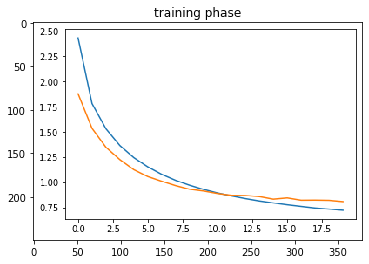

In [44]:
# plot losses in training phase
# blue one - loss
# orange one - val_loss
from PIL import Image
img = Image.open(r'training.png')
plt.title('training phase')
plt.imshow(img)
plt.show()

### Results

In [14]:
# load back saved encoder and decoder models for test phase
encoder = load_model('3dr/encoder_model.h5')
decoder = load_model('3dr/decoder_model.h5')

In [54]:
def translate_random_sentence_from_test_set(x, y):
    '''
    function to translate random sentence from preprocessed test set
    
    x: input test dataset
    y; output test dataset
    '''
    
    # choose random index
    idx = np.random.randint(len(x))
    
    # convert back chosen sentence to texts
    to_translate = fr_tokenizer.sequences_to_texts([x[idx]])[0]
    
    # invert back the sentence
    to_translate = to_translate.split(' ')[::-1]
    
    # create string from tokens
    original_fr = ' '.join(to_translate)
    
    # get the actual translation of chosen example
    actual_en = en_tokenizer.sequences_to_texts([y[idx]])[0]
    
    # strip <start> and <end> tokens
    actual_en = ' '.join(actual_en.split()[1:-1])
    
    # expand dims for encoder
    sample_expanded = np.expand_dims(x[idx], axis=0)
    
    # generate hidden state for Decoder model
    hidden_state = encoder.predict(sample_expanded)
    
    # initialize with zeros input sequence for decoder
    decoder_input = np.zeros((1, max_en_len), dtype='int')
    
    # translated result
    output_seq = ''
    
    # initialize first token with <start>
    token = en_tokenizer.word_index['<start>']
    
    # index used to measure length of translated senquence
    index = 0
    
    # generate translation
    while index < max_en_len and token != en_tokenizer.word_index['<end>']:
        
        # insert current token 
        decoder_input[:, index] = token
        
        # rename inputs for decoder
        x_data = \
        {
            'dec_hidden_state': hidden_state,
            'dec_input_seq': decoder_input
        }
        
        # predict next token
        dec_output = decoder.predict(x_data)
        
        # get the predicted token
        last_token = dec_output[:, index, :]
        
        # get the index of the token
        token = np.argmax(last_token)
        
        # convert index to actual word in tokenizer
        predicted_word = en_tokenizer.index_word[token]
        
        # append work to output sequence
        if predicted_word != '<end>':
            output_seq += predicted_word + ' '
        
        # increment the index
        index += 1
        
    # print results
    print('ORIGINAL FRENCH:')
    print(original_fr, '\n')
    print('TRANSLATION:')
    print(output_seq, '\n')
    print('ACTUAL:')
    print(actual_en, '\n')

In [63]:
translate_random_sentence_from_test_set(xtest, ytest)

ORIGINAL FRENCH:
devrait on en parler autour d'un café 

TRANSLATION:
should we talk to a cup of coffee  

ACTUAL:
shall we talk about it over a cup of coffee 



In [65]:
# example translations
for i in range(10):
    translate_random_sentence_from_test_set(xtest, ytest)
    print('#'*50)

ORIGINAL FRENCH:
il est dix heures vingt 

TRANSLATION:
it's ten o'clock  

ACTUAL:
it is twenty minutes past ten 

##################################################
ORIGINAL FRENCH:
apprécies tu ta nouvelle classe 

TRANSLATION:
do you like your new new class  

ACTUAL:
how do you like your new class 

##################################################
ORIGINAL FRENCH:
je n'arrive pas à fonctionner sans toi 

TRANSLATION:
i can't live without you  

ACTUAL:
i can't function without you 

##################################################
ORIGINAL FRENCH:
ses dents furent blanches 

TRANSLATION:
his teeth were white  

ACTUAL:
his teeth were white 

##################################################
ORIGINAL FRENCH:
tom aime manger de la pizza froide au petit déjeuner 

TRANSLATION:
tom likes to eat lunch with the pizza for lunch  

ACTUAL:
tom likes to eat cold pizza for breakfast 

##################################################
ORIGINAL FRENCH:
je pourrais facilement m'y habitue

In [64]:
def translate_sentence(sent, actual=None):
    '''
    function to translate given sentence in string form
    
    sent:   sentence to translate
    actual: translation to check model results
    '''
    
    # tokenize sentence
    tokenized = fr_tokenizer.texts_to_sequences([sent])[0]
    
    # reverse 
    tokenized = tokenized[::-1]
    
    # padding
    padded = pad_sequences([tokenized], padding='pre', maxlen=max_fr_len)[0]
    
    sample_expanded = np.expand_dims(padded, axis=0)
    hidden_state = encoder.predict(sample_expanded)
    decoder_input = np.zeros((1, max_en_len), dtype='int')
    
    output_seq = ''
    token = en_tokenizer.word_index['<start>']
    index = 0
    
    while index < max_en_len and token != en_tokenizer.word_index['<end>']:
        decoder_input[:, index] = token
        
        x_data = \
        {
            'dec_hidden_state': hidden_state,
            'dec_input_seq': decoder_input
        }
        
        dec_output = decoder.predict(x_data)
        last_token = dec_output[:, index, :]
        token = np.argmax(last_token)
        
        predicted_word = en_tokenizer.index_word[token]
        
        if predicted_word != '<end>':
            output_seq += predicted_word + ' '
        
        index += 1
    
    print('ORIGINAL FRENCH:')
    print(sent, '\n')
    print('TRANSLATION:')
    print(output_seq, '\n')
    if actual:
        print('ACTUAL:')
        print(actual, '\n')

In [67]:
# randomly chosen sentences from file
# there is a great chance they were in train dataset
# however their purpose is just to check whether function works or not
sent = "Je ne suis pas vraiment en colère contre toi."
target = "I'm not really mad at you."

In [66]:
translate_sentence(sent, target)

ORIGINAL FRENCH:
Je ne suis pas vraiment en colère contre toi. 

TRANSLATION:
i'm not very angry with you  

ACTUAL:
I'm not really mad at you. 

